## Collaborative Filtering
Collaborative filtering (CF) is probably the most common paradigm of recommender systems.  It is based on the idea that 
people *collaborate* with each other to *filter* products of interest. 

For instance, suppose that Amy and Bob both like a number of similar audio products such as speakers, headphones and so on. 
Amy likes a new wireless headset which Bob is not aware of. Chances are that Bob will like it too. 

Collaborative filtering is based on **the previous behavior** of **similar users**. Let us understand colloborative filtering with an example. If person A likes 3 movies, say Interstellar, Inception and Predestination, and person B likes Inception, Predestination and The Prestige, then they have almost similar interests. We can say with some certainty that A should like The Prestige and B should like Interstellar. The collaborative filtering algorithm uses “User Behavior” for recommending items. This is one of the most commonly used algorithms in the industry as it is not dependent on any additional information. There are different types of collaborating filtering techniques and we shall look at them in detail below

A collaborative filtering model leverages user ratings of movies they have already rated to predict ratings of movies they have not yet rated. An item-user matrix of all unique items is created with implicit factors against which each item is scored. Similarly, a user-item matrix is created with the same implicit factors against which each user is scored. These two matrices are used to impute scores for user and item combinations which are not part of the dataset or which are predictions. The imputed scores are used to make recommendations to each user.

We will focus on *model-based* collaborative filtering, which constructs 
attempts to model the user-item preferences and fits this model with data. 

**Explicit and Implicit Feedback**:
- In some applications, *explicit feedback* is available. For instance, when a user reviews a product on Amazon, likes a video on YouTube or a song on Spotify, and so on.
- On the other hand, one might only have to rely on *implicit feedback*, which is inferred from user behavior. For instance, a user clicked on an ad or a product recommendation, we use that to conclude that the user liked the product in question. Other examples include clicking a certain product on Amazon, duration a user watched a YouTube video and so on. 

**Downsides**:

- Explicit feedback is not always available as many users may be reluctant to rate products. 
- While implicit feedback is more readily available, it can be quite noisy. For instance, a user watched a movie does not necessarily indicate a positive view of that movie.
        
Often, one must use all kinds of feedback available in order to build a good recommender system.

## User-User collaborative filtering
The algorithm finds the similarity between each user based on the ratings they have previously given to different movies. The predictions can be calculated using the similarity values. This algorithm, first of all calculates the similarity between each user and then based on each similarity calculates the predictions. Users having higher correlation will tend to be similar. Based on these prediction values, recommendations are made.

## Item-Item collaborative filtering
In this algorithm, we compute the similarity between each pair of items. We will find the similarity between each movie pair and based on that, we will recommend similar movies which are liked by the users in the past. Find such users who have rated those items and based on the ratings, similarity between the items is calculated. 

## The MovieLens dataset

We will use the [MovieLens](https://grouplens.org/datasets/movielens/) dataset, 
which contains the ratings (1-5) assigned to various movies by various users.

The MovieLens 100k dataset is a stable benchmark dataset with 100,000 ratings given by 943 users for 1682 movies, with each user having rated at least 20 movies.

Suppose we have $m$ users and $n$ items. 
Usually, each user only sees a small number of items. Therefore, this 
user-item interaction matrix will be *extremely* sparse. 

In [213]:
import torch
import numpy as np
import os, sys, time 
import pandas as pd

import zipfile, tarfile, requests  # TODO: Ensure package requests is installed

import matplotlib.pyplot as plt
%matplotlib inline

In [214]:
def read_data_ml100k():
    data_url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
    
    def download_and_extract_data(url):
        """Download and extract a zip/tar file."""
        directory = './data'
        if not os.path.exists(directory):
            os.makedirs(directory)
        fname = os.path.join('./data', url.split('/')[-1])
        
        if os.path.exists(fname):
            print(f'File {fname} already exists. Reading it')
        else:
            print(f'Downloading {fname} from {url}...')
            r = requests.get(url, stream=True, verify=True)
            with open(fname, 'wb') as f:
                f.write(r.content)

        base_dir = os.path.dirname(fname)
        data_dir, ext = os.path.splitext(fname)
        if ext == '.zip':
            fp = zipfile.ZipFile(fname, 'r')
        elif ext in ('.tar', '.gz'):
            fp = tarfile.open(fname, 'r')
        else:
            assert False, 'Only zip/tar files can be extracted.'
        fp.extractall(base_dir)
        print('Done!')
        return data_dir

    data_dir = download_and_extract_data(data_url)
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,engine='python')
    movies = pd.read_csv(os.path.join(data_dir, 'u.item'), '\t', names=['movies'],engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, movies, num_users, num_items

In [215]:
# prepare movie rating data for inputing in the sparse matrix
def get_movies_ratings(movies):
    res=[]
    id=[]
    for row in movies['movies']:
        movie_id = row.split('|')[0]
        id.append(int(movie_id))
        movie = row.split('|')[1]
        movie = movie.split('(')[0]
        res.append(movie)
    return pd.DataFrame({"item_id":id,"name":res},columns=["item_id","name"])

In [216]:
data, movies, num_users, num_items = read_data_ml100k()
movies = get_movies_ratings(movies)
directory = './output'
if not os.path.exists(directory):
    os.makedirs(directory)
data.to_pickle("./output/ratings.pkl")
movies.to_pickle("./output/movies.pkl")

File ./data/ml-100k.zip already exists. Reading it
Done!


In [217]:
print(data.shape, num_users, num_items)
print(f'We have {data.shape[0]} ratings from {num_users} users and {num_items} items')
print()
print(movies.head(3))
print()
print(data.head(3))

(100000, 4) 943 1682
We have 100000 ratings from 943 users and 1682 items

   item_id         name
0        1   Toy Story 
1        2   GoldenEye 
2        3  Four Rooms 

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116


In [218]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [219]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   item_id  1682 non-null   int64 
 1   name     1682 non-null   object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


Check for duplicated values

In [220]:
print('Duplicated rows: ' + str(data.duplicated().sum()))

Duplicated rows: 0


94% of the ratings are missing. Implicit recommendations or matrix completion excel where data is sparse, it can often be helpful to make the interactions matrix a little more dense.

In [221]:
sparsity = 1 - len(data) / (num_users * num_items)
print(sparsity)

0.9369533063577546


## Matrix Factorization

The principle underlying matrix factorization is that each user-item interaction rating 
is explained by a small number of *latent factors*. 

Suppose we have $m$ users and $n$ items.
Let $R \in \mathbb{R}^{m \times n}$ be a rating matrix where $R_{ui}$ denotes the rating 
given by user $u$ to item $i$. 

Concretely, each user $u$ can be described by a vector $p_u \in \mathbb{R}^f$ and each item $i$ can be described by a vector $q_i \in \mathbb{R}^f$. Then the rating given to item $i$ by user $u$ is simply the dot product
$$
    \hat R_{ui} = p_u^\top q_i + b_u + b_i \,,
$$
where $b_u, b_i \in \mathbb{R}$ are respectively the biases of user $u$ and item $i$.

Image credits: D2L.ai
![image](http://d2l.ai/_images/rec-mf.svg)


Stacking the user factors into a matrix $P \in \mathbb{R}^{m \times f}$ 
and item factors into a matrix $Q \in \mathbb{R}^{n \times f}$, this model can be written as 
$$
    \hat R = P Q^\top + {b_U} \vec{1}_n^\top + \vec{1}_m {b_I}^\top \,,
$$
where ${b_U} \in \mathbb{R}^m$ and ${b_I} \in \mathbb{R}^n$ are the bias vectors obtained by stacking each of the biases into a vector, and $\vec{1}$ denotes the vector of all ones. 

The objective is simply the square loss between the available ratings and the reconstructions (i.e., the reconstruction error):

$$
    \min_{P, Q, b_U, b_I} \frac{1}{N} \sum_{j=1}^N (R_{u_j, i_j} - \hat R_{u_j, i_j})^2 
         + \lambda ( \|P\|_F^2 + \|Q\|_F^2) \,,
$$
where $\lambda$ is a regularization parameter.

The concept of ratings is introduced as a binary implied preferences (has the user observed the item or not) with a numeric confidence weight representing the assumed strength of that binary preference. This model formulation is the basis of the popular implicit feedback ALS algorithm. Here user_id is the unique ID of different users and each movie is also assigned a unique ID. A rating of 0.0 represents that the user has not rated that particular movie (1 is the lowest rating a user can give). We want to predict these missing ratings. Using matrix factorization, we can find some latent features that can determine how a user rates a movie. We decompose the matrix into constituent parts in such a way that the product of these parts generates the original matrix.

Let us assume that we have to find k latent features. So we can divide our rating matrix R(MxN) into P(MxK) and Q(NxK) such that P x QT (here QT is the transpose of Q matrix) approximates the R matrix:

 where:

M is the total number of users

N is the total number of movies

K is the total latent features

R is MxN user-movie rating matrix

P is MxK user-feature affinity matrix which represents the association between users and features

Q is NxK item-feature relevance matrix which represents the association between movies and features

Σ is KxK diagonal feature weight matrix which represents the essential weights of features

## Matrix Factorization using ALS

Given that each users have rated some items in the system, we would like to predict how the users would rate the items that they have not yet rated, such that we can make recommendations to the users. In this case, all the information we have about the existing ratings can be represented in a matrix.


The idea of matrix factorization is basically to take a very large matrix and split it up into two smaller matrices whose product equals the original one. Alternating Least Squares is a form of matrix factorization that reduces this user-item matrix to a much smaller amount of dimension called latent or hidden features. Essentially, we take a large matrix of user/item interactions and figure out the latent (or hidden) features that relate them to each other in a much smaller matrix of user features and item features. That’s exactly what ALS is trying to do through matrix factorization.

Let’s assume we have an original ratings matrix R of size MxN, where M is the number of users and N is the number of items. This matrix is quite sparse, since most users only interact with a few items each. We can factorize this matrix into two separate smaller matrices: one with dimensions MxK which will be our latent user feature vectors for each user (U) and a second with dimensions KxN, which will have our latent item feature vectors for each item (V). Multiplying these two feature matrices together approximates the original matrix, but now we have two matrices that are dense including a number of latent features K for each of our items and users.


In the case of ALS, we only need to solve one feature vector at a time, which means it can be run in parallel. To do this, we can randomly initialize U and solve for V. Then we can go back and solve for U using our solution for V. Keep iterating back and forth like this until we get a convergence that approximates R as best as we can.

After this has been finished, we can simply take the dot product of U and V to see what the predicted rating would be for a specific user/item interaction, even if there was no prior interaction.

The recommendations get filtered based on the collaboration between similar user’s preferences. The algorithm learns by itself what features to use.

1)Each user item interaction is explained by some amount of latent factors

2)The rating is a dot product of user vector and product vector

3) Bias term for item and movies captures the average rating.

## Processing data

In [222]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from scipy.sparse import csr_matrix, save_npz, load_npz
import os, sys, time 
import csv
import matplotlib.pyplot as plt

Create a visualization  for the distribution of ratings and drop the time stamp column

In [223]:
def process_data(data):
    data.drop('timestamp',inplace=True,axis=1,errors='ignore')
    #Seeing the distribution of ratings given by the users
    print("See Overview of the Data")
    p = data.groupby('rating')['rating'].agg(['count'])
    # get movie count
    movie_count = data.item_id.unique().shape[0]
    # get customer count
    cust_count = data.user_id.unique().shape[0]
    # get rating count
    rating_count = data['user_id'].count()
    ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
    plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
    plt.axis('off')
    for i in range(1,6):
        ax.text(p.iloc[i-1][0]/4, i-1, 'Rated {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold',fontsize=15)

    directory = 'images'
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig('images/DistributionOfRatings.jpg')
    return data, cust_count, movie_count

We implemented the collaborative filtering model using a module called csr_matrix from scipy.sparse package. As
seen in the code cell below, we have generated item-user and user-item matrices to conduct latent factor analysis
which is the computation of scores based on implicit factors as previously described. The sparse user-item and item-user matrix are the inputs for the machine learning model. 

If you think about it, our matrix is going to contain thousands of items and thousands of users with a user/item value required for every possible combination. That is a LARGE matrix, so we can save a lot of memory by keeping the matrix sparse and only saving the locations and values of items that are not zero.

In [224]:
def create_sparse_matrix(data):
    # Drop any rows that have 0 ratings
    data_matrix = data.loc[data.rating != 0]
    
    users = list(np.sort(data_matrix.user_id.unique())) # Get our unique users
    items = list(np.sort(data_matrix.item_id.unique())) # Get our unique movies 
    rating = list(data_matrix.rating) # All of our ratings

    rows = data_matrix.user_id.astype(CategoricalDtype(categories=users)).cat.codes 
    cols = data_matrix.item_id.astype(CategoricalDtype(categories=items)).cat.codes
    
    # The implicit library expects data as a item-user matrix so we
    # create two matricies, one for fitting the model (item-user) 
    # and one for recommendations (user-item)
    sparse_item_user = csr_matrix((rating, (cols, rows)), shape=(len(items), len(users)))
    sparse_user_item = csr_matrix((rating, (rows, cols)), shape=(len(users), len(items)))
    print("Sparse matrices created : sparse_item_user ", sparse_item_user.shape, "sparse_user_item" ,sparse_user_item.shape)
    return sparse_item_user,sparse_user_item,users,items

See Overview of the Data
(100000, 3) 943 1682
We have 100000 ratings from 943 users and 1682 items
Sparse matrices created : sparse_item_user  (1682, 943) sparse_user_item (943, 1682)
sparsity : 93.69533063577546


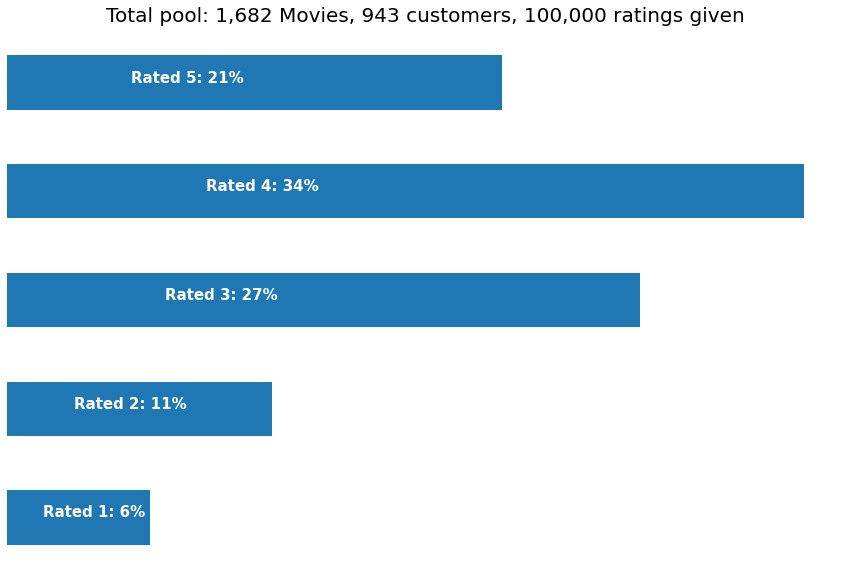

In [225]:
data = pd.read_pickle("./output/ratings.pkl")
data, num_users, num_items = process_data(data)
print(data.shape, num_users, num_items)
print(f'We have {data.shape[0]} ratings from {num_users} users and {num_items} items')
sparse_item_user,sparse_user_item,users,items = create_sparse_matrix(data)

matrix_size = sparse_user_item.shape[0]*sparse_user_item.shape[1] # Number of possible interactions in the matrix
num_rating = len(sparse_user_item.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_rating/matrix_size))
print("sparsity :",sparsity)
  
directory = './output'
if not os.path.exists(directory):
    os.makedirs(directory)
      
save_npz("./output/sparse_item_user.npz", sparse_item_user)
save_npz("./output/sparse_user_item.npz", sparse_user_item)

## Creating a Training and Test Set
Typically in Machine Learning applications, we need to test whether the model we just trained is any good on new data it hasn’t yet seen before from the training phase. We do this by creating a test set completely separate from the training set. With collaborative filtering, that’s not going to work because you need all of the user/item interactions to find the proper matrix factorization. A better method is to hide a certain percentage of the user/item interactions from the model during the training phase chosen at random. Then, check during the test phase how many of the items or movies that were recommended to a user actually ended up being rated in the end. 

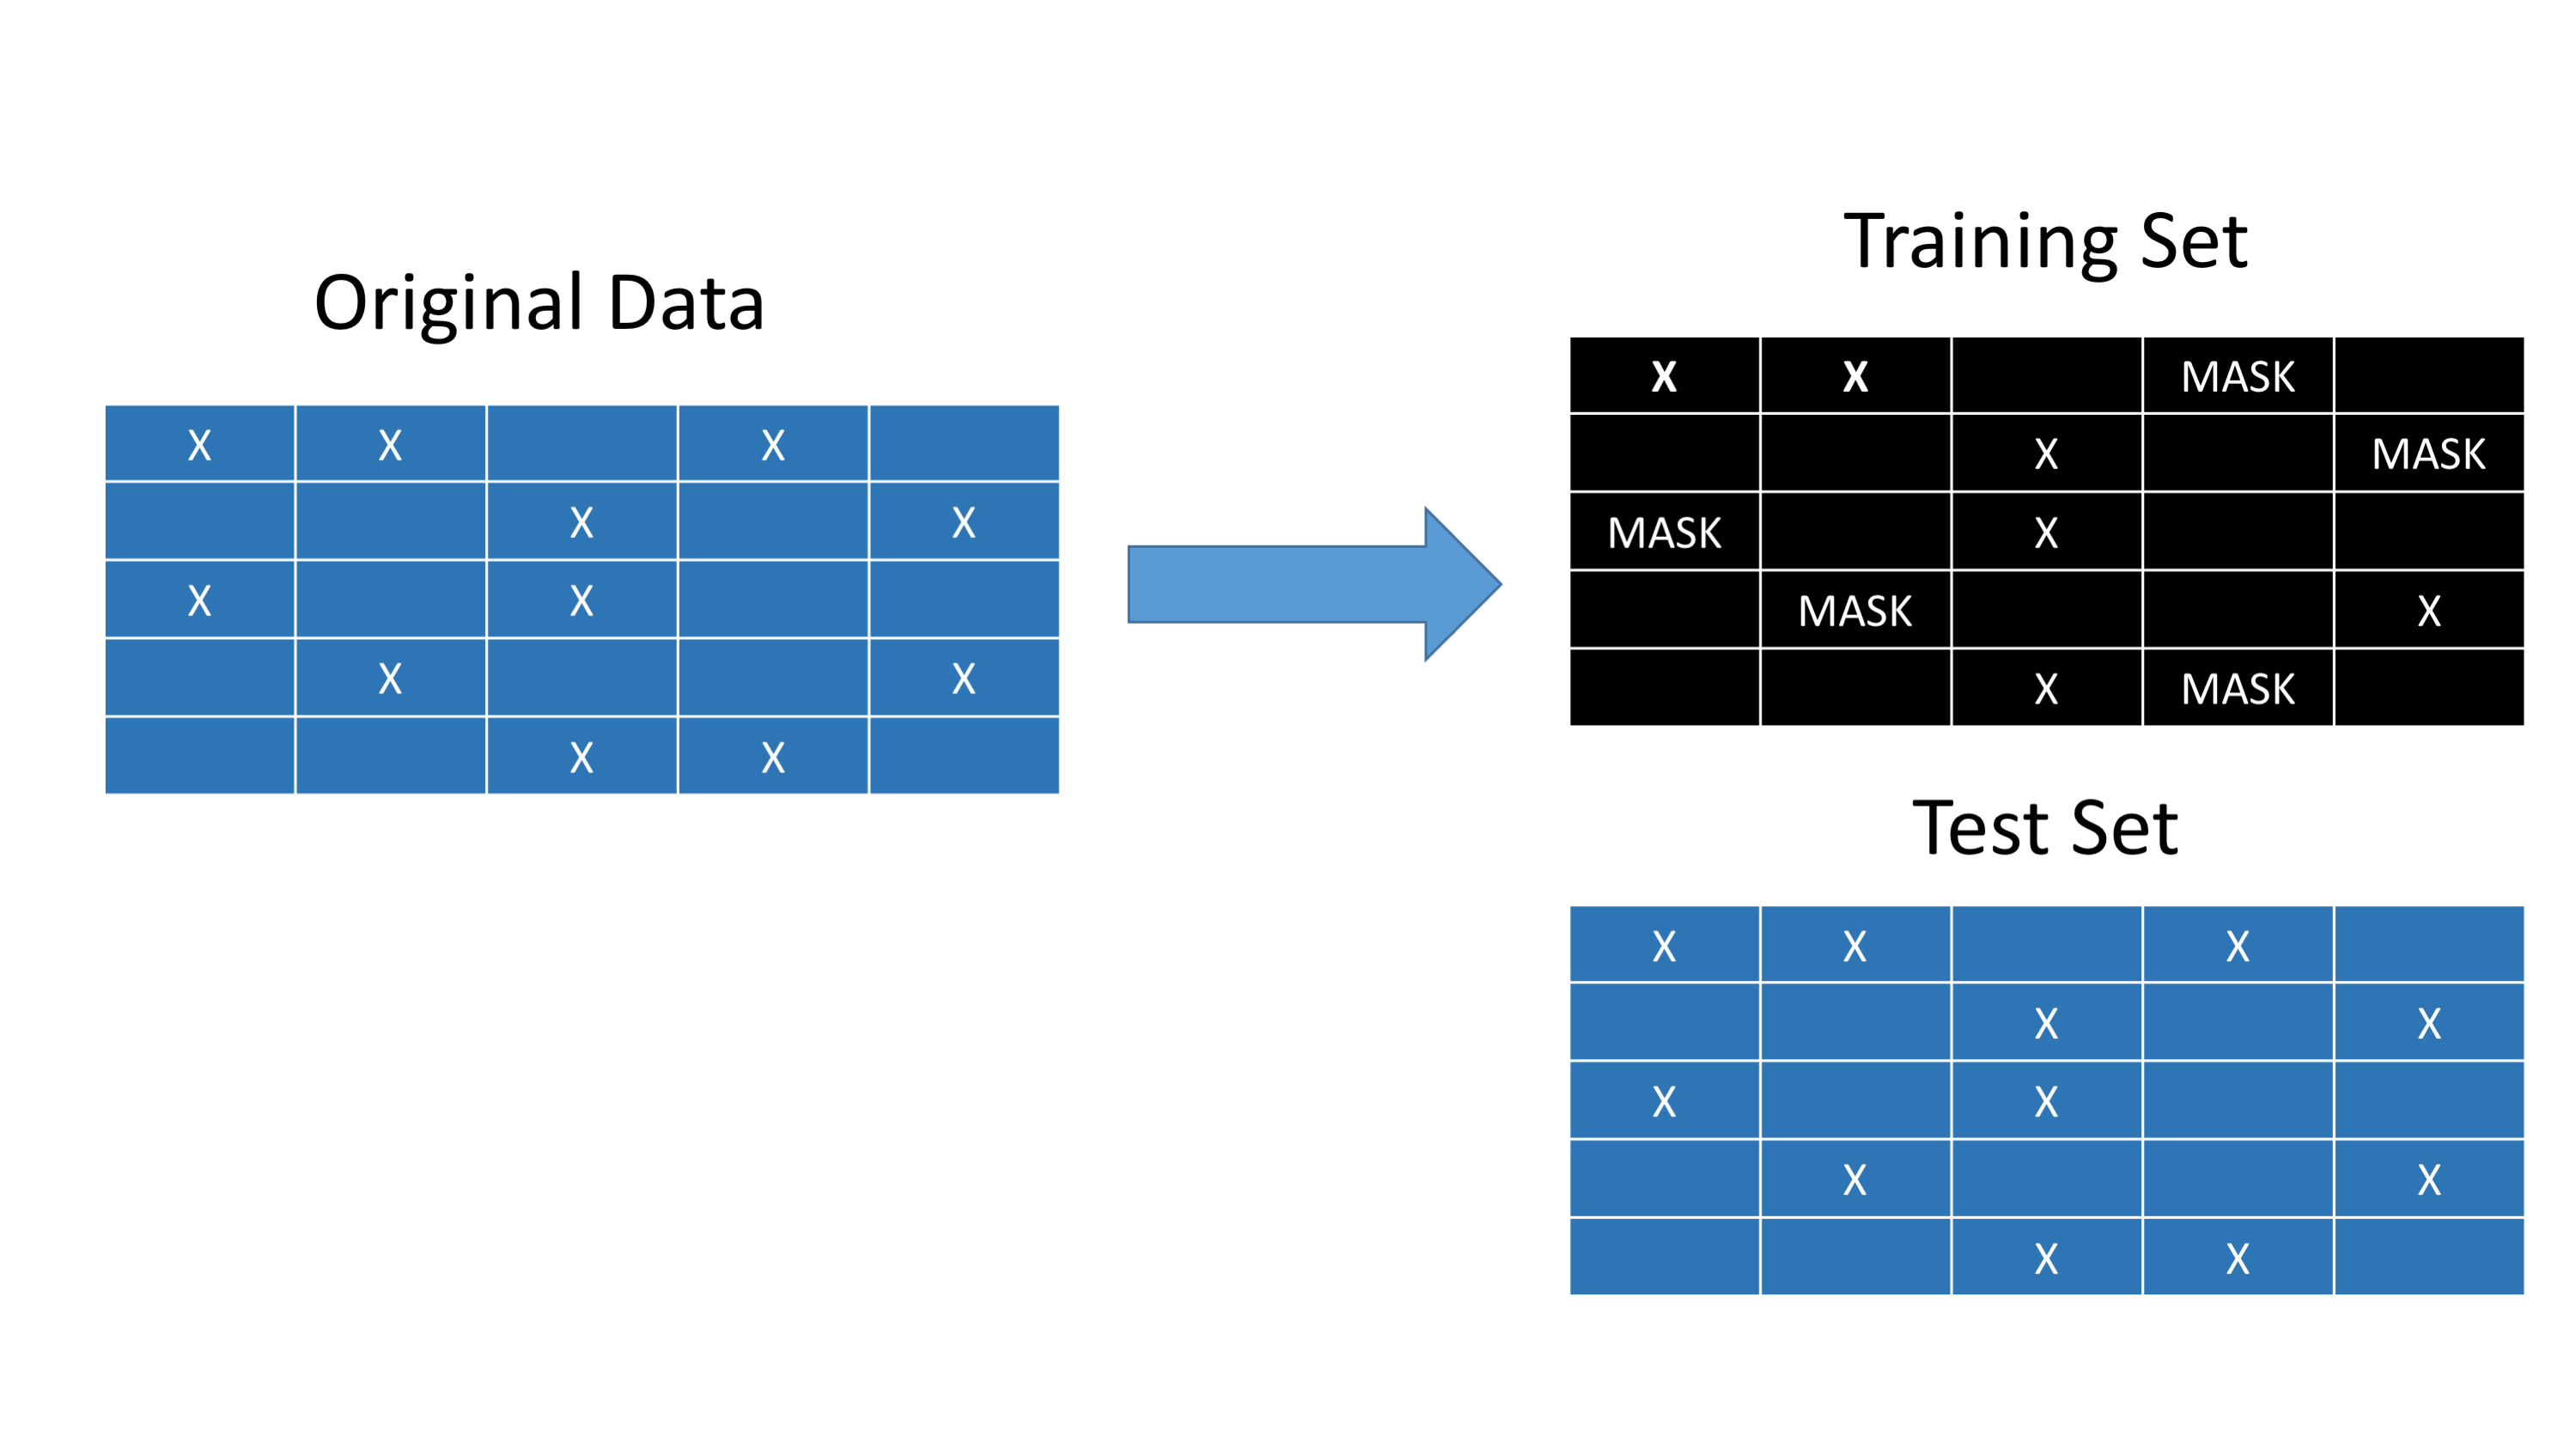

Our test set is an exact copy of our original data. The training set, however, will mask a random percentage of user/item interactions and act as if the user never rated the item (making it a sparse entry with a zero). We then check in the test set which items/movies were recommended to the user that they ended up actually rating. If the users frequently ended up rating the movies most recommended to them by the system, we can conclude the system seems to be working. As an additional check, we can compare our system to simply recommending the most popular items to every user. This will be our baseline.

The below code will return our training set, a test set that has been binarized to 0/1 for not-rated/rated, and a list of which users had at least one item masked. We will test the performance of the recommender system on these users only. We are masking 20% of the user/item interactions  in the training set.

This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a user-item interaction has taken place for use as a train set. The test set will contain all of the original ratings, while the training set replaces the specified percentage of them with a zero in the original ratings matrix. It returns training set, test set and 

1) ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete copy of the original set. This is in the form of a sparse csr_matrix. 
    
2) pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the training set for later comparison to the test set, which contains all of the original ratings. 
    
3)training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
4)test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.

5)user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.

In [226]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, save_npz, load_npz
import random
import implicit
from sklearn import metrics
import os, sys, time 
import csv
import pickle

In [227]:
def test_train_split(sparse_user_item):
    ratings = sparse_user_item
    pct_test = 0.2
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    train_data, test_data, users_altered = training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered
    print("Train test split done! ",train_data.shape, test_data.shape)
    return train_data, test_data, users_altered 

In [228]:
train_data, test_data, users_altered = test_train_split(sparse_user_item)

Train test split done!  (943, 1682) (943, 1682)


## Implementing ALS for Implicit Feedback

We merge the preference (p) for an item with the confidence (c) we have for that preference. We start out with missing values as a negative preference with a low confidence value and existing values a positive preference but with a high confidence value.

Set the preference (p) using binary representation of our feedback data r. If the feedback is greater than zero we set it to 1. 
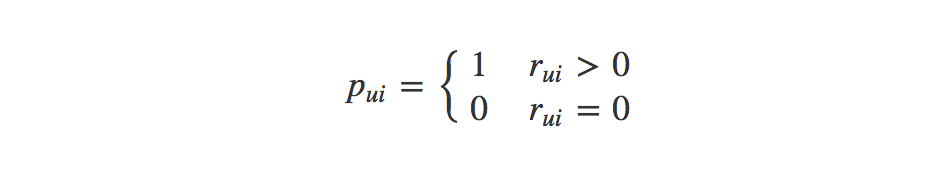

Calculate the confidence using the magnitude of r (the feedback data) giving us a larger confidence the more rating a user has given. The rate of which our confidence increases is set through a linear scaling factor α. We also add 1 so we have a minimal confidence even if α x r equals zero.

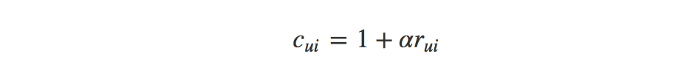

1. First, we have our ratings matrix which is sparse (represented by the train_data sparse matrix object). We need to turn this explicit ratings into a confidence matrix by multiplying explicit ratings matrix by α .
2. The α term represents a linear scaling of the rating preferences (in our case ratings) 
    
    Cui=1+αrui where Cui is the confidence matrix for our users u and our items i and the rui term is our original matrix of ratings. We start with  α =40 as a good starting point.
    
3. We use implicit ALS for Python utilizing Cython and parallelizing the code among threads.

We used a package called implict to implement alternating least squares
method of training the model to minimize errors and produce optimal recommendations.

The way a collaborative filtering model is trained and assessed is through iterations of an algorithm called Alternating Least Squares, which computes a cost function for the imputed ratings from which recommendations are derived. The cost function calculates the mean squared errors for each score in the matrix that maps users to implicit factors (u) and each score in the matrix which maps each item to implicit factors (v) against the actual ratings in the dataset (r). This error is minimized by first updating u to minimize v and then updating v to minimize u over many iterations. By increasing the number of iterations, the model will tend to stabilize u and v, achieving optimal output.

The collaborative filtering model can also take in hyperparameters which can be tuned for increased accuracy.
The hyperparameters used in the model are the number of factors, regularization, and alpha. The number of
factors is the number of implicit factors that are generated by the model to map with each user and each item.
Regularization and alpha are used to normalize the scores in the matrices used the in model.

We have four parameters that we would like to optimize:

1. num_factors: The number of latent factors, or degree of dimensionality in our model.

2. regularization: Scale of regularization for both user and item factors.

3. alpha: Our confidence scaling term.

4. iterations: Number of iterations to run Alternating Least Squares optimization.

In [229]:
def train_model(train_data):   
    # Initialize the als model and fit it using the sparse item-user matrix
    als_model = implicit.als.AlternatingLeastSquares(factors=20, 
                                                     regularization=1e-3, 
                                                     iterations=50)
    # Calculate the confidence by multiplying it by our alpha value.
    alpha_val = 40
    data_conf = (train_data * alpha_val).astype('double') # train data is of item-user format
    als_model.fit(data_conf)
    # Get the user and item vectors from our trained model
    user_vecs = als_model.user_factors
    item_vecs = als_model.item_factors
    print("Model trained, user vectors and item vectors shape",user_vecs.shape,item_vecs.shape)
    return als_model,user_vecs,item_vecs

In [230]:
als_model,user_vecs,item_vecs = train_model(train_data.T) # the parameter to trail_model should be item - user matrix
  
directory = './output'
if not os.path.exists(directory):
    os.makedirs(directory)
np.save('./output/item_vecs', item_vecs)
np.save('./output/user_vecs', user_vecs)
  
with open('./output/als_model', 'wb') as file:
    pickle.dump(als_model, file)


Model trained, user vectors and item vectors shape (943, 20) (1682, 20)


## Evaluating the Recommender System

Our training set has 20% of the ratings masked. This will allow us to evaluate the performance of our recommender system. Essentially, we need to see if the order of recommendations given for each user matches the movies they ended up rating. A commonly used metric for this kind of problem is the area under the Receiver Operating Characteristic (or ROC) curve. A greater area under the curve means we are recommending items that end up being rated near the top of the list of recommended items. Usually this metric is used in more typical binary classification problems to identify how well a model can predict a positive example vs. a negative one. It will also work well for our purposes of ranking recommendations.

In order to do that, we need to write a function that can calculate a mean area under the curve (AUC) for any user that had at least one masked item. As a benchmark, we will also calculate what the mean AUC would have been if we had simply recommended the most popular items. Popularity tends to be hard to beat in most recommender system problems, so it makes a good comparison.

First, let’s make a simple function that can calculate our AUC. Scikit-learn has one we can alter a bit.

The calc_mean_auc will calculate the mean AUC by user for any user that had their user-item matrix altered and returns mean AUC. 
    
1) taining_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
2) predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
3) altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
4) test_set - The test set constucted earlier from make_train function
    
5) The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions There were originally zero to test ranking ability in addition to the most popular items as a benchmark.

    

In [231]:
def evaluate_model(training_set, altered_users, predictions, test_set):
    def auc_score(predictions, test):
        fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
        return metrics.auc(fpr, tpr)
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1)
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
        # End users iteration    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  

Now, utilize this helper function inside of a second function that will calculate the AUC for each user in our training set that had at least one rating masked. It should also calculate AUC for the most popular items for our users to compare.

We can now use this function to see how our recommender system is doing. To use this function, we will need to transform our output from the ALS function to csr_matrix format and transpose the item vectors. 

In [232]:
print("implicit_recomm_auc,popularity_auc",evaluate_model(train_data, users_altered,[csr_matrix(user_vecs), csr_matrix(item_vecs.T)], test_data))

implicit_recomm_auc,popularity_auc (0.918, 0.863)


We can see that our recommender system beat popularity. Our system had a mean AUC of 0.917, while the popular item benchmark had a lower AUC of 0.862. 

## Testing this with examples

We need to find a way of retrieving the movies already rated by a user in the training set. The below function tells us which moviues have been rated by a specific user in the training set

parameters: 
    
1)user_id - Input the user's id number that you want to see prior rating of at least once
    
2) train_data - The initial ratings training set used (without weights applied)
    
3) users_list - The array of users used in the ratings matrix
    
4) items_list - The array of movies used in the ratings matrix
    
5) movies - A simple pandas dataframe of the unique movie ID/descriptions available
    
returns: A list of item IDs and item descriptions for a particular customer that were already rated in the training set


We can see that the user rated a few movies. What items does the recommender system say this user should watch.

In [233]:
def get_movies_rated(user_id, train_data,movies):
    data_matrix = data.loc[data.rating != 0]
    users = list(np.sort(data_matrix.user_id.unique())) # Get our unique users
    items = list(np.sort(data_matrix.item_id.unique())) # Get our unique movies 
    users_arr = np.array(users) # Array of user IDs from the ratings matrix
    items_arr = np.array(items) # Array of movie IDs from the ratings matrix
    user_ind = np.where(users_arr == user_id)[0][0] # Returns the index row of our user id
    rating_ind = train_data[user_ind,:].nonzero()[1] # Get column indices of rated items
    movie_codes = items_arr[rating_ind] # Get the movie ids for our rated items
    return movies.loc[movies['item_id'].isin(movie_codes),'name'].reset_index(drop=True)

In [170]:
user_id = 234
movies_rated_by_users = get_movies_rated(user_id, train_data, movies)
print(movies_rated_by_users )

0              Toy Story
1              GoldenEye
2             Get Shorty
3                Copycat
4         Twelve Monkeys
             ...        
373     Madame Butterfly
374            Sleepover
375    Here Comes Cookie
376              Thieves
377            Boys, Les
Name: name, Length: 378, dtype: object


In [234]:
def predict_ratings(predictions,item_vecs,user_id):
    item_vecs = predictions[1]
    user_vec = predictions[0][user_id,:]
    pred = user_vec.dot(item_vecs).toarray()[0].reshape(-1)
    return pred
    
def similar_items(model,movie_list,n_similar=20):
    # Use implicit to get similar items.
    movies.name = movies.name.str.strip()
    item_id = movies.item_id.loc[movies.name.str.lower().isin([s.lower() for s in movie_list])].iloc[0]
    movie_names = []
    similar = model.similar_items(item_id, n_similar)
    # Print the names of similar movies
    for item in similar:
        idx, rating = item
        movie_names.append(movies.name.loc[movies.item_id == idx+1].iloc[0])
    similar = pd.DataFrame({"Similar Movies":movie_names[1:]})
    return similar
            
def recommendations(model,sparse_user_item,user_id):
    # Use the implicit recommender.
    recommended = model.recommend(user_id, sparse_user_item)
    movies_recom = []
    ratings_recom = []
    # Get movie names from ids
    for item in recommended:
        idx, rating = item
        movies_recom.append((movies.name.loc[movies.item_id == idx+1].iloc[0]))
        #ratings_recom.append(rating)
    # Create a dataframe of movie names and scores
    #recommendations = pd.DataFrame({'Movies': movies_recom, 'Rating': ratings_recom})
    movies_rated_by_users = get_movies_rated(user_id, train_data, movies)
    minlen  = min(len(movies_recom),len(movies_rated_by_users))
    recommendations = pd.DataFrame({'Recommended Movies': movies_recom[:minlen], 'Movies Rated': movies_rated_by_users[:minlen]})
    return recommendations

In [235]:
from tabulate import tabulate    
movie_list=['picnic']
user_id=135
n_similar=41
predictions = [csr_matrix(user_vecs), csr_matrix(item_vecs.T)]       
predictRatings = predict_ratings(predictions,item_vecs,user_id)
actualRatings = test_data[user_id,:].toarray().reshape(-1)
ratings_df = pd.DataFrame({"Predicted Ratings":predictRatings,"Actual Ratings":actualRatings})
ratings_df.index += 1
        
similar_df = similar_items(als_model,movie_list,n_similar)
similar_df.index += 1 
        
recomm_df = recommendations(als_model,sparse_user_item,user_id)
recomm_df.index += 1 
        
print()
print("************************** TOP 20 RATINGS FOR USER :" +str(user_id) +" ****************")
print()
print(tabulate(ratings_df[:20], tablefmt="pipe", headers="keys"))
print()
print("************************** "+str(n_similar - 1) +" MOVIES SIMILAR TO :" +str(movie_list) +"  *****************")
print()
print(tabulate(similar_df, tablefmt="pipe", headers="keys"))
print()
print("************************** RECOMMEDATIONS FOR USER :" +str(user_id) +" ******************")
print()
print(tabulate(recomm_df, tablefmt="pipe", headers="keys"))
print()
print("*************************************************************************************")         


************************** TOP 20 RATINGS FOR USER :135 ****************

|    |   Predicted Ratings |   Actual Ratings |
|---:|--------------------:|-----------------:|
|  1 |            1.03391  |                0 |
|  2 |            0.197555 |                0 |
|  3 |            0.106389 |                0 |
|  4 |            0.704126 |                0 |
|  5 |            0.516846 |                0 |
|  6 |            0.220392 |                0 |
|  7 |            1.05513  |                0 |
|  8 |            0.773831 |                0 |
|  9 |            1.05865  |                1 |
| 10 |            0.779888 |                0 |
| 11 |            0.783609 |                0 |
| 12 |            0.843259 |                0 |
| 13 |            0.979598 |                0 |
| 14 |            1.01646  |                1 |
| 15 |            1.01151  |                1 |
| 16 |            0.515205 |                0 |
| 17 |            0.414999 |                0 |
| 18 |       

## References

https://jessesw.com/Rec-System/

https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe